<a href="https://colab.research.google.com/github/ethanp55/Forex-AI/blob/master/forex_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install talib for technical indicators
# %%capture will suppress all output - these commands produce way too many
#   output statments
%%capture
! wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
! tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
! ./configure --prefix=/usr
! make
! make install
! pip install Ta-Lib

### Imports and file path

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objects as go
import webbrowser
import math
import talib
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Lambda, BatchNormalization
from tensorflow.keras.layers import Convolution2D, MaxPool2D, AveragePooling2D, add, concatenate
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import time

file_path = '/content/drive/My Drive/Forex_AI/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Mount google drive for accessing files
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Read in and clean/prepare data

In [17]:
df = pd.read_csv(file_path + 'EURUSD_Candlestick_15_M_2003-2020.csv')
df.rename(columns={'Gmt time': 'Date'}, inplace=True)
df.Date = pd.to_datetime(df.Date, format='%d.%m.%Y %H:%M:%S.%f')
df.drop_duplicates(subset=df.columns.difference(['Date']), keep=False, inplace=True)

df

,Date,Bid_Open,Bid_High,Bid_Low,Bid_Close,Bid_Volume,Ask_Open,Ask_High,Ask_Low,Ask_Close,Ask_Volume
84,2003-05-04 21:00:00,1.12284,1.12338,1.12256,1.12312,7872.300,1.12354,1.12354,1.12294,1.12332,6451.40
85,2003-05-04 21:15:00,1.12312,1.12319,1.12242,1.12297,6172.200,1.12322,1.12338,1.12281,1.12307,5218.70
86,2003-05-04 21:30:00,1.12287,1.12313,1.12280,1.12295,7581.000,1.12303,1.12325,1.12296,1.12305,6231.10
87,2003-05-04 21:45:00,1.12301,1.12308,1.12264,1.12305,7433.600,1.12316,1.12331,1.12279,1.12331,6305.40
88,2003-05-04 22:00:00,1.12274,1.12284,1.12250,1.12250,6878.000,1.12290,1.12299,1.12264,1.12274,6005.00
...,...,...,...,...,...,...,...,...,...,...,...
596623,2020-05-08 19:45:00,1.08376,1.08392,1.08356,1.08370,1632.790,1.08380,1.08396,1.08359,1.08374,1531.75
596624,2020-05-08 20:00:00,1.08371,1.08386,1.08346,1.08351,597.840,1.08374,1.08390,1.08348,1.08354,693.55
596625,2020-05-08 20:15:00,1.08349,1.08377,1.08349,1.08362,324.920,1.08353,1.08382,1.08352,1.08366,353.57
596626,2020-05-08 20:30:00,1.08362,1.08381,1.08353,1.08376,311.060,1.08364,1.08387,1.08356,1.08383,475.28


In [0]:
# # Plot the data
# trace = go.Figure(go.Ohlc(x=df.Date, open=df.Open, high=df.High,
#                                low=df.Low, close=df.Close, name='Currency Quote'))
# trace.show(renderer="colab")

,Bid_Open,Bid_High,Bid_Low,Bid_Close,Bid_Volume,Ask_Open,Ask_High,Ask_Low,Ask_Close,Ask_Volume,sin_hour,cos_hour,sin_day,cos_day,sin_month,cos_month
84,1.12284,1.12338,1.12256,1.12312,7872.3,1.12354,1.12354,1.12294,1.12332,6451.4,-0.707107,0.707107,-0.433884,-0.900969,0.5,-0.866025
85,1.12312,1.12319,1.12242,1.12297,6172.2,1.12322,1.12338,1.12281,1.12307,5218.7,-0.707107,0.707107,-0.433884,-0.900969,0.5,-0.866025
86,1.12287,1.12313,1.12280,1.12295,7581.0,1.12303,1.12325,1.12296,1.12305,6231.1,-0.707107,0.707107,-0.433884,-0.900969,0.5,-0.866025
87,1.12301,1.12308,1.12264,1.12305,7433.6,1.12316,1.12331,1.12279,1.12331,6305.4,-0.707107,0.707107,-0.433884,-0.900969,0.5,-0.866025
88,1.12274,1.12284,1.12250,1.12250,6878.0,1.12290,1.12299,1.12264,1.12274,6005.0,-0.500000,0.866025,-0.433884,-0.900969,0.5,-0.866025


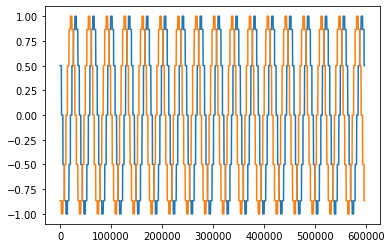

In [18]:
# Add hour of day, day of week, and month of year (for additional features)
# Use sine and cosine to keep the cyclic nature of hour, day, and month
#  (December is closer to January than October, midnight is closer to 1 am than
#  10 pm, etc.)
df['sin_hour'] = np.sin(2 * np.pi * df['Date'].dt.hour / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['Date'].dt.hour / 24)
df['sin_day'] = np.sin(2 * np.pi * df['Date'].dt.day / 7)
df['cos_day'] = np.cos(2 * np.pi * df['Date'].dt.day / 7)
df['sin_month'] = np.sin(2 * np.pi * df['Date'].dt.month / 12)
df['cos_month'] = np.cos(2 * np.pi * df['Date'].dt.month / 12)

# Drop the original date column (it is no longer needed)
df.drop('Date', axis=1, inplace=True)

# Plots to illustrate cyclic nature of time
df.sin_month.plot()
df.cos_month.plot()

# Show the updated dataframe
df.head()

In [19]:
# Add technical indicators (for additional features)
# Bid technical indicators
df['Bid_SMA1'] = talib.SMA(df['Bid_Close'], timeperiod=10)
df['Bid_SMA1_Envelope_Upper'] = df['Bid_SMA1'] + (0.1 * df['Bid_SMA1'])
df['Bid_SMA1_Envelope_Lower'] = df['Bid_SMA1'] - (0.1 * df['Bid_SMA1'])
df['Bid_EMA1'] = talib.EMA(df['Bid_Close'], timeperiod=10)
df['Bid_EMA1_Envelope_Upper'] = df['Bid_EMA1'] + (0.1 * df['Bid_EMA1'])
df['Bid_EMA1_Envelope_Lower'] = df['Bid_EMA1'] - (0.1 * df['Bid_EMA1'])
df['Bid_SMA2'] = talib.SMA(df['Bid_Close'], timeperiod=20)
df['Bid_SMA2_Envelope_Upper'] = df['Bid_SMA2'] + (0.1 * df['Bid_SMA2'])
df['Bid_SMA2_Envelope_Lower'] = df['Bid_SMA2'] - (0.1 * df['Bid_SMA2'])
df['Bid_EMA2'] = talib.EMA(df['Bid_Close'], timeperiod=20)
df['Bid_EMA2_Envelope_Upper'] = df['Bid_EMA2'] + (0.1 * df['Bid_EMA2'])
df['Bid_EMA2_Envelope_Lower'] = df['Bid_EMA2'] - (0.1 * df['Bid_EMA2'])
df['Bid_SMA3'] = talib.SMA(df['Bid_Close'], timeperiod=30)
df['Bid_SMA3_Envelope_Upper'] = df['Bid_SMA3'] + (0.1 * df['Bid_SMA3'])
df['Bid_SMA3_Envelope_Lower'] = df['Bid_SMA3'] - (0.1 * df['Bid_SMA3'])
df['Bid_EMA3'] = talib.EMA(df['Bid_Close'], timeperiod=30)
df['Bid_EMA3_Envelope_Upper'] = df['Bid_EMA3'] + (0.1 * df['Bid_EMA3'])
df['Bid_EMA3_Envelope_Lower'] = df['Bid_EMA3'] - (0.1 * df['Bid_EMA3'])
df['Bid_BB_Upper_Band'], df['Bid_BB_Middle_Band'], df['Bid_BB_Lower_Band'] = talib.BBANDS(
    df['Bid_Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
df['Bid_MACD'], df['Bid_MACD_Signal'], df['Bid_MACD_hist'] = talib.MACD(df['Bid_Close'],
                                                            fastperiod=12,
                                                            slowperiod=26,
                                                            signalperiod=9)
df['Bid_Parabollic_SAR'] = talib.SAR(df['Bid_High'], df['Bid_Low'], acceleration=0, maximum=0)
df['Bid_Slowk'], df['Bid_Slowd'] = talib.STOCH(df['Bid_High'], df['Bid_Low'], df['Bid_Close'],
                                       fastk_period=5, slowk_period=3,
                                       slowk_matype=0, slowd_period=3,
                                       slowd_matype=0)
df['Bid_RSI'] = talib.RSI(df['Bid_Close'], timeperiod=14)
df['Bid_Williams_Percent_Range'] = talib.WILLR(df['Bid_High'], df['Bid_Low'], df['Bid_Close'],
                                           timeperiod=14)
df['Bid_ADX'] = talib.ADX(df['Bid_High'], df['Bid_Low'], df['Bid_Close'], timeperiod=14)
df['Bid_ADXR'] = talib.ADXR(df['Bid_High'], df['Bid_Low'], df['Bid_Close'], timeperiod=14)
df['Bid_MOM'] = talib.MOM(df['Bid_Close'], timeperiod=10)
df['Bid_BOP'] = talib.BOP(df['Bid_Open'], df['Bid_High'], df['Bid_Low'], df['Bid_Close'])
df['Bid_AROONOSC'] = talib.AROONOSC(df['Bid_High'], df['Bid_Low'], timeperiod=14)
df['Bid_ATR'] = talib.ATR(df['Bid_High'], df['Bid_Low'], df['Bid_Close'], timeperiod=14)

# Ask technical indicators
df['Ask_SMA1'] = talib.SMA(df['Ask_Close'], timeperiod=10)
df['Ask_SMA1_Envelope_Upper'] = df['Ask_SMA1'] + (0.1 * df['Ask_SMA1'])
df['Ask_SMA1_Envelope_Lower'] = df['Ask_SMA1'] - (0.1 * df['Ask_SMA1'])
df['Ask_EMA1'] = talib.EMA(df['Ask_Close'], timeperiod=10)
df['Ask_EMA1_Envelope_Upper'] = df['Ask_EMA1'] + (0.1 * df['Ask_EMA1'])
df['Ask_EMA1_Envelope_Lower'] = df['Ask_EMA1'] - (0.1 * df['Ask_EMA1'])
df['Ask_SMA2'] = talib.SMA(df['Ask_Close'], timeperiod=20)
df['Ask_SMA2_Envelope_Upper'] = df['Ask_SMA2'] + (0.1 * df['Ask_SMA2'])
df['Ask_SMA2_Envelope_Lower'] = df['Ask_SMA2'] - (0.1 * df['Ask_SMA2'])
df['Ask_EMA2'] = talib.EMA(df['Ask_Close'], timeperiod=20)
df['Ask_EMA2_Envelope_Upper'] = df['Ask_EMA2'] + (0.1 * df['Ask_EMA2'])
df['Ask_EMA2_Envelope_Lower'] = df['Ask_EMA2'] - (0.1 * df['Ask_EMA2'])
df['Ask_SMA3'] = talib.SMA(df['Ask_Close'], timeperiod=30)
df['Ask_SMA3_Envelope_Upper'] = df['Ask_SMA3'] + (0.1 * df['Ask_SMA3'])
df['Ask_SMA3_Envelope_Lower'] = df['Ask_SMA3'] - (0.1 * df['Ask_SMA3'])
df['Ask_EMA3'] = talib.EMA(df['Ask_Close'], timeperiod=30)
df['Ask_EMA3_Envelope_Upper'] = df['Ask_EMA3'] + (0.1 * df['Ask_EMA3'])
df['Ask_EMA3_Envelope_Lower'] = df['Ask_EMA3'] - (0.1 * df['Ask_EMA3'])
df['Ask_BB_Upper_Band'], df['Ask_BB_Middle_Band'], df['Ask_BB_Lower_Band'] = talib.BBANDS(
    df['Ask_Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
df['Ask_MACD'], df['Ask_MACD_Signal'], df['Ask_MACD_hist'] = talib.MACD(df['Ask_Close'],
                                                            fastperiod=12,
                                                            slowperiod=26,
                                                            signalperiod=9)
df['Ask_Parabollic_SAR'] = talib.SAR(df['Ask_High'], df['Ask_Low'], acceleration=0, maximum=0)
df['Ask_Slowk'], df['Ask_Slowd'] = talib.STOCH(df['Ask_High'], df['Ask_Low'], df['Ask_Close'],
                                       fastk_period=5, slowk_period=3,
                                       slowk_matype=0, slowd_period=3,
                                       slowd_matype=0)
df['Ask_RSI'] = talib.RSI(df['Ask_Close'], timeperiod=14)
df['Ask_Williams_Percent_Range'] = talib.WILLR(df['Ask_High'], df['Ask_Low'], df['Ask_Close'],
                                           timeperiod=14)
df['Ask_ADX'] = talib.ADX(df['Ask_High'], df['Ask_Low'], df['Ask_Close'], timeperiod=14)
df['Ask_ADXR'] = talib.ADXR(df['Ask_High'], df['Ask_Low'], df['Ask_Close'], timeperiod=14)
df['Ask_MOM'] = talib.MOM(df['Ask_Close'], timeperiod=10)
df['Ask_BOP'] = talib.BOP(df['Ask_Open'], df['Ask_High'], df['Ask_Low'], df['Ask_Close'])
df['Ask_AROONOSC'] = talib.AROONOSC(df['Ask_High'], df['Ask_Low'], timeperiod=14)
df['Ask_ATR'] = talib.ATR(df['Ask_High'], df['Ask_Low'], df['Ask_Close'], timeperiod=14)

df

,Bid_Open,Bid_High,Bid_Low,Bid_Close,Bid_Volume,Ask_Open,Ask_High,Ask_Low,Ask_Close,Ask_Volume,sin_hour,cos_hour,sin_day,cos_day,sin_month,cos_month,Bid_SMA1,Bid_SMA1_Envelope_Upper,Bid_SMA1_Envelope_Lower,Bid_EMA1,Bid_EMA1_Envelope_Upper,Bid_EMA1_Envelope_Lower,Bid_SMA2,Bid_SMA2_Envelope_Upper,Bid_SMA2_Envelope_Lower,Bid_EMA2,Bid_EMA2_Envelope_Upper,Bid_EMA2_Envelope_Lower,Bid_SMA3,Bid_SMA3_Envelope_Upper,Bid_SMA3_Envelope_Lower,Bid_EMA3,Bid_EMA3_Envelope_Upper,Bid_EMA3_Envelope_Lower,Bid_BB_Upper_Band,Bid_BB_Middle_Band,Bid_BB_Lower_Band,Bid_MACD,Bid_MACD_Signal,Bid_MACD_hist,...,Bid_ADXR,Bid_MOM,Bid_BOP,Bid_AROONOSC,Bid_ATR,Ask_SMA1,Ask_SMA1_Envelope_Upper,Ask_SMA1_Envelope_Lower,Ask_EMA1,Ask_EMA1_Envelope_Upper,Ask_EMA1_Envelope_Lower,Ask_SMA2,Ask_SMA2_Envelope_Upper,Ask_SMA2_Envelope_Lower,Ask_EMA2,Ask_EMA2_Envelope_Upper,Ask_EMA2_Envelope_Lower,Ask_SMA3,Ask_SMA3_Envelope_Upper,Ask_SMA3_Envelope_Lower,Ask_EMA3,Ask_EMA3_Envelope_Upper,Ask_EMA3_Envelope_Lower,Ask_BB_Upper_Band,Ask_BB_Middle_Band,Ask_BB_Lower_Band,Ask_MACD,Ask_MACD_Signal,Ask_MACD_hist,Ask_Parabollic_SAR,Ask_Slowk,Ask_Slowd,Ask_RSI,Ask_Williams_Percent_Range,Ask_ADX,Ask_ADXR,Ask_MOM,Ask_BOP,Ask_AROONOSC,Ask_ATR
84,1.12284,1.12338,1.12256,1.12312,7872.300,1.12354,1.12354,1.12294,1.12332,6451.40,-0.707107,0.707107,-0.433884,-0.900969,0.5,-0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.341463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.366667,NaN,NaN
85,1.12312,1.12319,1.12242,1.12297,6172.200,1.12322,1.12338,1.12281,1.12307,5218.70,-0.707107,0.707107,-0.433884,-0.900969,0.5,-0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.194805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.263158,NaN,NaN
86,1.12287,1.12313,1.12280,1.12295,7581.000,1.12303,1.12325,1.12296,1.12305,6231.10,-0.707107,0.707107,-0.433884,-0.900969,0.5,-0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.242424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.068966,NaN,NaN
87,1.12301,1.12308,1.12264,1.12305,7433.600,1.12316,1.12331,1.12279,1.12331,6305.40,-0.707107,0.707107,-0.433884,-0.900969,0.5,-0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.090909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.288462,NaN,NaN
88,1.12274,1.12284,1.12250,1.12250,6878.000,1.12290,1.12299,1.12264,1.12274,6005.00,-0.500000,0.866025,-0.433884,-0.900969,0.5,-0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.123353,1.122918,1.122483,NaN,NaN,NaN,...,NaN,NaN,-0.705882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.123523,1.123098,1.122673,NaN,NaN,NaN,1.12354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.457143,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596623,1.08376,1.08392,1.08356,1.08370,1632.790,1.08380,1.08396,1.08359,1.08374,1531.75,-0.965926,0.258819,0.781831,0.623490,0.5,-0.866025,1.084214,1.192635,0.975793,1.084068,1.192475,0.975662,1.084591,1.193050,0.976132,1.084261,1.192687,0.975835,1.084315,1.192746,0.975883,1.084277,1.192705,0.975849,1.084243,1.083764,1.083285,-0.000146,0.000020,-0.000165,...,15.732641,-0.00118,-0.1666

In [29]:
%%time

# A 3-day lookback period is a pretty wide window for day trading.  With
#  15-minute intervals, we need 288 instances to look back 3 days.
subset_size = 200

subset = df.iloc[0:subset_size, :]

# Scale each column to be between -1 and 1
for j in range(subset.shape[1]):
  if not (subset.iloc[:, j].max() <= 1 and subset.iloc[:, j].min() >= -1):
    subset.iloc[:, j] = ((subset.iloc[:, j] - subset.iloc[:, j].max()) + (subset.iloc[:, j] - subset.iloc[:, j].min())) / (subset.iloc[:, j].max() - subset.iloc[:, j].min())

# Find RP matrix before converting values to arc cosine values
# See the paper found at https://arxiv.org/pdf/1710.00886.pdf
RP = []

for i in range(subset.shape[0]):
  RP_curr_row = []

  for j in range(subset.shape[0]):
    RP_curr_row.append(np.linalg.norm(subset.iloc[i, :] - subset.iloc[j, :]))

  RP.append(RP_curr_row)

RP = np.expand_dims(RP, axis=0)

# Change data to arc cosine values (in order to find GASF and GADF)
for j in range(subset.shape[1]):
  for i in range(subset.shape[0]):
    subset.iloc[i, j] = math.acos(subset.iloc[i, j])

subset.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CPU times: user 22.6 s, sys: 595 ms, total: 23.2 s
Wall time: 22.2 s


In [30]:
%%time
# Convert time series data to rich image data
# See the following papers:
#   https://arxiv.org/pdf/1908.08036.pdf pages 4 and 5 for Gram matrices in general
#   https://arxiv.org/pdf/1506.00327.pdf page 2 for GASF and GADF in specific
GASF = []
GADF = []

for j in range(subset.shape[1]):
  GASF_curr_matrix = []
  GADF_curr_matrix = []

  for i in range(subset.shape[0]):
    GASF_curr_row = []
    GADF_curr_row = []

    for k in range(subset.shape[0]):
      GASF_curr_row.append(math.cos(subset.iloc[i, j] + subset.iloc[k, j]))
      GADF_curr_row.append(math.sin(subset.iloc[i, j] - subset.iloc[k, j]))

    GASF_curr_matrix.append(GASF_curr_row)
    GADF_curr_matrix.append(GADF_curr_row)

  GASF.append(GASF_curr_matrix)
  GADF.append(GADF_curr_matrix)

GASF = np.array(GASF)
GADF = np.array(GADF)

print('GASF shape: ' + str(GASF.shape))
print('GADF shape: ' + str(GADF.shape))
print('RP shape: ' + str(RP.shape))

image_data = np.append(GASF.reshape((subset_size, subset_size, -1)),
                       GADF.reshape((subset_size, subset_size, -1)), axis=-1)
image_data = np.append(image_data, RP.reshape((subset_size, subset_size, -1)),
                       axis=-1)
print('Final image data shape: ' + str(image_data.shape))

GASF shape: (86, 200, 200)
GADF shape: (86, 200, 200)
RP shape: (1, 200, 200)
Final image data shape: (200, 200, 173)
CPU times: user 1min 36s, sys: 130 ms, total: 1min 36s
Wall time: 1min 36s


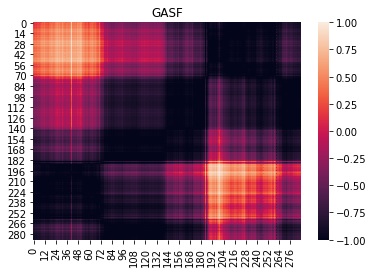

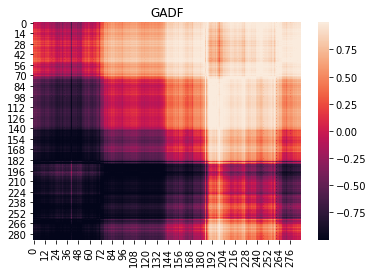

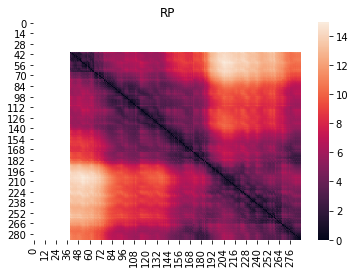

In [25]:
# Plot sample heat maps
ax = sns.heatmap(GASF[0])
ax.set_title('GASF')
plt.show()
ax = sns.heatmap(GADF[0])
ax.set_title('GADF')
plt.show()
ax = sns.heatmap(RP[0])
ax.set_title('RP')
plt.show()

### Function for grabbing subsets of data (re-use of the code from the previous section, but crammed into a single function)

In [0]:
def grab_image_data(start_index, subset_size=200):
  subset = df.iloc[0:subset_size, :]

  # Scale each column to be between -1 and 1
  for j in range(subset.shape[1]):
    if not (subset.iloc[:, j].max() <= 1 and subset.iloc[:, j].min() >= -1):
      subset.iloc[:, j] = ((subset.iloc[:, j] - subset.iloc[:, j].max()) + (subset.iloc[:, j] - subset.iloc[:, j].min())) / (subset.iloc[:, j].max() - subset.iloc[:, j].min())

  # Find RP matrix before converting values to arc cosine values
  # See the paper found at https://arxiv.org/pdf/1710.00886.pdf
  RP = []

  for i in range(subset.shape[0]):
    RP_curr_row = []

    for j in range(subset.shape[0]):
      RP_curr_row.append(np.linalg.norm(subset.iloc[i, :] - subset.iloc[j, :]))

    RP.append(RP_curr_row)

  RP = np.expand_dims(RP, axis=0)

  # Change data to arc cosine values (in order to find GASF and GADF)
  for j in range(subset.shape[1]):
    for i in range(subset.shape[0]):
      subset.iloc[i, j] = math.acos(subset.iloc[i, j])

  # Convert time series data to rich image data
  # See the following papers:
  #   https://arxiv.org/pdf/1908.08036.pdf pages 4 and 5 for Gram matrices in general
  #   https://arxiv.org/pdf/1506.00327.pdf page 2 for GASF and GADF in specific
  GASF = []
  GADF = []

  for j in range(subset.shape[1]):
    GASF_curr_matrix = []
    GADF_curr_matrix = []

    for i in range(subset.shape[0]):
      GASF_curr_row = []
      GADF_curr_row = []

      for k in range(subset.shape[0]):
        GASF_curr_row.append(math.cos(subset.iloc[i, j] + subset.iloc[k, j]))
        GADF_curr_row.append(math.sin(subset.iloc[i, j] - subset.iloc[k, j]))

      GASF_curr_matrix.append(GASF_curr_row)
      GADF_curr_matrix.append(GADF_curr_row)

    GASF.append(GASF_curr_matrix)
    GADF.append(GADF_curr_matrix)

  GASF = np.array(GASF)
  GADF = np.array(GADF)

  image_data = np.append(GASF.reshape((subset_size, subset_size, -1)),
                        GADF.reshape((subset_size, subset_size, -1)), axis=-1)
  image_data = np.append(image_data, RP.reshape((subset_size, subset_size, -1)),
                        axis=-1)

  return image_data


### Inception-ResNet-v2

In [0]:
reduction_factor = 8

def inception_resnet_v2_stem(x):
    # In the paper the stride here is 2
    x = Convolution2D(filters=32//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='valid')(x)
    x = Convolution2D(filters=32//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='valid')(x)
    x = Convolution2D(filters=64//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    
    # In the paper the stride here is 2
    a = MaxPool2D(pool_size=(3, 3), strides=1, padding='valid')(x)
    # In the paper the stride here is 2
    b = Convolution2D(filters=96//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='valid')(x)
    x = concatenate([a, b], axis=-1)
    
    a = Convolution2D(filters=64//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    a = Convolution2D(filters=96//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='valid')(a)
    b = Convolution2D(filters=64//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    b = Convolution2D(filters=64//reduction_factor, kernel_size=(7, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(b)
    b = Convolution2D(filters=64//reduction_factor, kernel_size=(1, 7), activation='relu',
                      kernel_initializer='he_normal', padding='same')(b)
    b = Convolution2D(filters=96//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='valid')(b)
    x = concatenate([a, b], axis=-1)
    
    # In the paper the stride here is 2
    a = Convolution2D(filters=192//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='valid')(x)
    # In the paper the stride here is 2
    b = MaxPool2D(pool_size=(3, 3), strides=1, padding='valid')(x)
    x = concatenate([a, b], axis=-1)
    
    x = Activation('relu')(x)
    
    return x


def inception_resnet_v2_A(x):
    skip_connection = x
    
    a = Convolution2D(filters=32//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    
    b = Convolution2D(filters=32//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    b = Convolution2D(filters=32//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='same')(b)
    
    c = Convolution2D(filters=32//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    c = Convolution2D(filters=48//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='same')(c)
    c = Convolution2D(filters=64//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='same')(c)
    
    x = concatenate([a, b, c], axis=-1)
    x = Convolution2D(filters=384//reduction_factor, kernel_size=(1, 1), activation='linear',
                      kernel_initializer='he_normal', padding='same')(x)
    
    x = add([skip_connection, x])
    x = Activation('relu')(x)
    
    return x


def inception_resnet_v2_reduction_A(x):
    a = MaxPool2D(pool_size=(3, 3), strides=2, padding='valid')(x)
    b = Convolution2D(filters=384//reduction_factor, kernel_size=(3, 3), strides=2, activation='relu',
                      kernel_initializer='he_normal', padding='valid')(x)
    c = Convolution2D(filters=256//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    c = Convolution2D(filters=256//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='same')(c)
    c = Convolution2D(filters=384//reduction_factor, kernel_size=(3, 3), strides=2, activation='relu',
                      kernel_initializer='he_normal', padding='valid')(c)
    x = concatenate([a, b, c], axis=-1)
    
    return x
    

def inception_resnet_v2_B(x):
    skip_connection = x
    
    a = Convolution2D(filters=192//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    
    b = Convolution2D(filters=128//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    b = Convolution2D(filters=160//reduction_factor, kernel_size=(1, 7), activation='relu',
                      kernel_initializer='he_normal', padding='same')(b)
    b = Convolution2D(filters=192//reduction_factor, kernel_size=(7, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(b)
    
    x = concatenate([a, b], axis=-1)
    x = Convolution2D(filters=1152//reduction_factor, kernel_size=(1, 1), activation='linear',
                      kernel_initializer='he_normal', padding='same')(x)
    
    x = add([skip_connection, x])
    x = Activation('relu')(x)
    
    return x


def inception_resnet_v2_reduction_B(x):
    a = MaxPool2D(pool_size=(3, 3), strides=2, padding='valid')(x)
    b = Convolution2D(filters=256//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    b = Convolution2D(filters=288//reduction_factor, kernel_size=(3, 3), strides=2, activation='relu',
                      kernel_initializer='he_normal', padding='valid')(b)
    c = Convolution2D(filters=256//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    c = Convolution2D(filters=288//reduction_factor, kernel_size=(3, 3), strides=2, activation='relu',
                      kernel_initializer='he_normal', padding='valid')(c)
    d = Convolution2D(filters=256//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    d = Convolution2D(filters=288//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='same')(d)
    d = Convolution2D(filters=320//reduction_factor, kernel_size=(3, 3), strides=2, activation='relu',
                      kernel_initializer='he_normal', padding='valid')(d)
    
    x = concatenate([a, b, c, d], axis=-1)
    
    return x


def inception_resnet_v2_C(x):
    shortcut = x
    
    a = Convolution2D(filters=192//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    
    b = Convolution2D(filters=192//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    b = Convolution2D(filters=224//reduction_factor, kernel_size=(1, 3), activation='relu',
                      kernel_initializer='he_normal', padding='same')(b)
    b = Convolution2D(filters=256//reduction_factor, kernel_size=(3, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(b)
    
    x = concatenate([a, b], axis=-1)
    x = Convolution2D(filters=2048//reduction_factor, kernel_size=(1, 1), activation='linear',
                      kernel_initializer='he_normal', padding='same')(x)
    
    x = add([shortcut, x])
    x = Activation('relu')(x)
    
    return x

In [32]:
%%time
# Number of possible actions to take - explained in detail in the first cell of 
#  the next section - determines the output dimension of the neural network
n_actions = 4
img_rows, img_cols = 200, 200
img_channels = 173

# In the paper these are 5, 10, and 5, respectively
num_A_blocks = 1
num_B_blocks = 1
num_C_blocks = 1

inputs = Input(shape=(img_rows, img_cols, img_channels))

x = inception_resnet_v2_stem(inputs)
for i in range(num_A_blocks):
    x = inception_resnet_v2_A(x)

x = inception_resnet_v2_reduction_A(x)

for i in range(num_B_blocks):
    x = inception_resnet_v2_B(x)

x = inception_resnet_v2_reduction_B(x)
for i in range(num_C_blocks):
    x = inception_resnet_v2_C(x)

x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
x = Dropout(0.5)(x)
x = Flatten()(x)

predictions = Dense(n_actions, activation='elu')(x)

model = Model(inputs=inputs, outputs=predictions)

model.summary()

(None, 94, 94, 144)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 17 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 198, 198, 4)  6232        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 196, 196, 4)  148         conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 196, 196, 8)  296         conv2d_40[0][0]                  
________________________________________________________________________

### DQN

In [0]:
# Here are the possible actions we will define:
#   - Buy
#   - Sell
#   - Close the current position(s)
#   - Do nothing/wait
n_actions = 4

# Very simple class used for determining current position(s)
# TODO: Add detailed explanation of this trading strategy (Sure-Fire Arbitrage Strategy)
class trade_state:
  def __init__(self, k=2): # TODO: Figure out what an appropriate k might be
    k = k
    first_position = ''
    first_position_price = None
    second_position = ''
    second_position_price = None
    third_position = ''
    third_position_price = None
